# Gelman Schools Theory for Topics about Restaurants

##### Keywords: normal-normal model, hierarchical normal-normal model, hierarchical, divergences, non-centered hierarchical model, sampling distribution

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm

From Gelman:

>a simple hierarchical model based on the normal distribu- tion, in which observed data are normally distributed with a different mean for each ‘group’ or ‘experiment,’ with known observation variance, and a normal population distribution for the group means. This model is sometimes termed the one-way normal random-effects model with known data variance and is widely applicable, being an important special case of the hierarchical normal linear model,...

## Statement of the model

The particular example we will deal with is called the 8-schools example, and is described thus:

>A study was performed for the Educational Testing Service to analyze the effects of special coaching programs on test scores. Separate randomized experiments were performed to estimate the effects of coaching programs for the SAT-V (Scholastic Aptitude Test- Verbal) in each of eight high schools. The outcome variable in each study was the score on a special administration of the SAT-V, a standardized multiple choice test administered by the Educational Testing Service and used to help colleges make admissions decisions; the scores can vary between 200 and 800, with mean about 500 and standard deviation about 100. The SAT examinations are designed to be resistant to short-term efforts directed specifically toward improving performance on the test; instead they are designed to reflect knowledge acquired and abilities developed over many years of education. Nevertheless, each of the eight schools in this study considered its short-term coaching program to be successful at increasing SAT scores. Also, there was no prior reason to believe that any of the eight programs was more effective than any other or that some were more similar in effect to each other than to any other.

>the estimated coaching effects are $\bar{y}_j$, and their sampling variances, $\sigma_j^2$... The estimates $\bar{y}_j$ are obtained by independent experiments and have approximately normal sampling distributions with sampling variances that are known, for all practical purposes, because the sample sizes in all of the eight experiments were relatively large, over thirty students in each school 

![](images/8schools.png)

Notice the bar on the y's and the mention of standard errors (rather than standard deviations) in the third column in the table above. Why is this?

The answer is that these are means taken over many (> 30) students in each of the schools. The general structure of this model can be written thus:

>Consider $J$ independent experiments, with experiment $j$ estimating the parameter $\theta_j$ from $n_j$ independent normally distributed data points, $y_{ij}$, each with known error variance $\sigma^2$; that is,

$$y_{ij} \vert \theta_j \sim N(\theta_j, \sigma^2), \, i = 1,...,n_j; j = 1,...,J.$$

![](images/school_model.png)

Thus there are $J=8$ schools, and in the $jth$ school, there are $n_j$ students. We are not given the scores of individual students, just the average score in the school: the so-called "sample-mean" (after all this is a sample of students from the school).

We label the sample mean of each group $j$ as

$$\bar{y_j} = \frac{1}{n_j} \sum_{i=1}^{n_j} y_{ij}$$

with sampling variance:

$$\sigma_j^2 = \sigma^2/n_j$$

  
>We can then write the likelihood for each $\theta_j$ using the sufficient statistics, $\bar{y}_j$:

$$\bar{y_j} \vert \theta_j \sim N(\theta_j,\sigma_j^2).$$

Since we are assuming the variance $\sigma^2$ is known from all the schools we have $$\sigma_j^2 = \sigma^2/n_j$$ to be the standard error of the sample-mean.

The idea is that if a particular school is very likely to have systematically positive treatment effect, we should be able to estimate that $\theta_j$ is relatively large and $\sigma_j^2$ is relatively small. If on the other hand, a school giving both positive and negative treatments we'll estimate $\theta_j$ around 0 and a relatively large variance $\sigma_j^2$.

This is

>a notation that will prove useful later because of the flexibility in allowing a separate variance $\sigma_j^2$ for the mean of each group $j$. ...all expressions will be implicitly conditional on the known values $\sigma_j^2$.... Although rarely strictly true, the assumption of known variances at the sampling level of the model is often an adequate approximation.

>The treatment of the model provided ... is also appropriate for situations in which the variances differ for reasons other than the number of data points in the experiment. In fact, the likelihood  can appear in much more general contexts than that stated here. For example, if the group sizes $n_j$ are large enough, then the means $\bar{y_j}$ are approximately normally distributed, given $\theta_j$, even when the data $y_{ij}$ are not. 

In other problems, like the one on your homework where we will use this model, you are given a $\sigma_j$ calculated from each group or unit. But since you will want  the variance of the sample mean, you will have to calculate the standard error by dividing out by the count in that unit.

## The model for the homework

![](images/restuarant_model.png)

We want to set up a Bayesian model for a reviewer $j$'s opinion of restaurant $k$'s food and service, separately. That is, you will have a model for each restaurant and each aspect (food and serivce). For restaurant $k$, you will have a model for $\{\theta_{jk}^{\text{food}}\}$ and one for $\{\theta_{jk}^{\text{service}}\}$, where $\theta_{jk}$ is the positivity of the opinion of the $j$-th reviewer regarding the $k$-th restaurant. 

To think about this, first just fix a restaurant, say $k=1$..and also fix an aspect, say food. Then the $\thetas$ are just like in the schools problem. We have a bunch of reviews for that restaurant. And each review, given an aspect, has a sample of sentences for the review. For each of these reviews (schools) we have a mean and a variance over the sentiment of the sentences

So now, consider the analogs: each review corresponds to a school, and we have a sample of sentences for the review. The multiple reviews (say 8) for a restarant are an analog to the 8 schools. So the overall "treatment" effect we are looking at is really the overall sentiment corresponding to an aspect (say service) of A GIVEN restaurant. 

Now think of the pooling going on here. Some reviews may say a lot about food and not much about service. Some may say a lot about both. What we are doing os pooling information across these reviews to estimate the overall "treatment": how good is this restaurant really for service, for example

You have to think what quantity in our data naturally corresponds to $\bar{y}_j$'s in the prep school example? How would you calculate the parameter $\sigma_j^2$ in the distribution of $\bar{y}_j$ (note that, contrary to the school example, $\sigma_j^2$ is not provided explictly in the restaurant data).

We want to use our model to produce estimates for $\theta_{jk}$'s. Se we will want to pick a few restaurants, for each aspect ("food" and "service") of each restaurant, plot our estimates for the $\theta$'s against the values in the "mean" column (corresponding to this restaurant). And this will shows us our shrinkage from the observed mean sentiments to some "pooled" sentiment.

Now you can rank restaurants by these pooled senitivities, with all the caveats that you noticed from the rubber-ducky problem.


## Setting up the hierarchical model for Gelman Schools

We'll set up the modelled in what is called a "Centered" parametrization which tells us how $\theta_i$ is modelled: it is written to be directly dependent as a normal distribution from the hyper-parameters. 

In [2]:
J = 8
y = np.array([28,  8, -3,  7, -1,  1, 18, 12])
sigma = np.array([15, 10, 16, 11,  9, 11, 10, 18])

We set up our priors in a Hierarchical model to use this centered parametrization. We can say: the $\theta_j$ is drawn from a Normal hyper-prior distribution with parameters $\mu$ and $\tau$. Once we get a $\theta_j$ then can draw the means from it given the data $\sigma_j$ and one such draw corresponds to our data.

$$
\mu \sim \mathcal{N}(0, 5)\\
\tau \sim \text{Half-Cauchy}(0, 5)\\
\theta_{j} \sim \mathcal{N}(\mu, \tau)\\
\bar{y_{j}} \sim \mathcal{N}(\theta_{j}, \sigma_{j})
$$

where $j \in \{1, \ldots, 8 \}$ and the
$\{ y_{j}, \sigma_{j} \}$ are given as data

### An equivalent model in a non-centered parametrization

We change our model to:

$$
\mu \sim \mathcal{N}(0, 5)\\
\tau \sim \text{Half-Cauchy}(0, 5)\\
\nu_{j} \sim \mathcal{N}(0, 1)\\
\theta_{j} = \mu + \tau\nu_j \\
\bar{y_{j}} \sim \mathcal{N}(\theta_{j}, \sigma_{j})
$$

Notice how we have factored the dependency of $\theta$ on $\phi = \mu, \tau$ into a deterministic
transformation between the layers, leaving the
actively sampled variables uncorrelated.

This does two things for us: it reduces steepness and curvature, making for better stepping. It also reduces the strong change in densities, and makes sampling from the transition distribution easier.

## Sampling

One can work out this problem using Gaussian Formulae and EB (whch requires some root-finding!), but we love our samplers so we will do sampling!

In [3]:
with pm.Model() as schools2:
    mu = pm.Normal('mu', mu=0, sd=5)
    tau = pm.HalfCauchy('tau', beta=5)
    nu = pm.Normal('nu', mu=0, sd=1, shape=J)
    theta = pm.Deterministic('theta', mu + tau * nu)
    obs = pm.Normal('obs', mu=theta, sd=sigma, observed=y)

In [4]:
with schools2:
    trace2 = pm.sample(10000, init=None, njobs=2, tune=1000)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, tau_log__, mu]
100%|██████████| 11000/11000 [00:21<00:00, 520.07it/s]
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1187e5588>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x118b73a58>]], dtype=object)

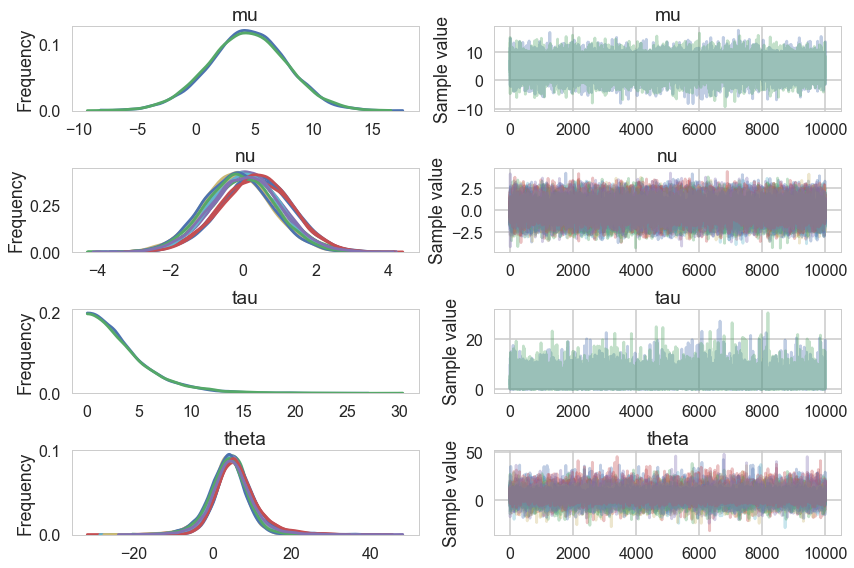

In [5]:
pm.traceplot(trace2)

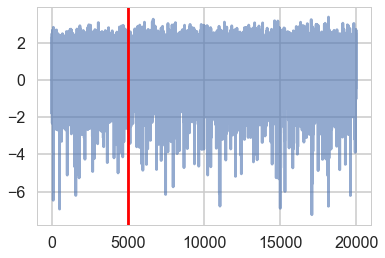

In [6]:
plt.plot(trace2['tau_log__'], alpha=0.6)
plt.axvline(5000, color="r")

In [7]:
pm.diagnostics.gelman_rubin(trace2), pm.diagnostics.effective_n(trace2)

({'mu': 1.0000526347451892,
  'nu': array([ 1.00003073,  1.00004073,  1.00031098,  0.99998064,  0.99997309,
          1.00032466,  0.99998265,  0.99996271]),
  'tau': 1.0003630401055388,
  'theta': array([ 1.00010116,  0.99995002,  1.00002645,  0.99995831,  1.00019463,
          1.00015296,  1.00006921,  0.99995178])},
 {'mu': 20000.0,
  'nu': array([ 20000.,  20000.,  20000.,  20000.,  20000.,  20000.,  20000.,
          20000.]),
  'tau': 12191.0,
  'theta': array([ 18662.,  20000.,  17823.,  20000.,  20000.,  20000.,  20000.,
          20000.])})

How about our divergences? They seem to be more than what we saw in class but note that we have double the number of samples and the divergences are distributed fairly uniformly so we are sure they are false positives.

In [9]:
divergent = trace2['diverging']
print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size/len(trace2)
print('Percentage of Divergent %.5f' % divperc)

Number of Divergent 21
Percentage of Divergent 0.00210


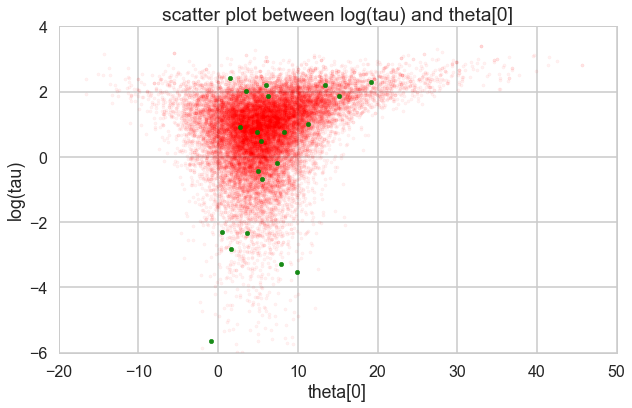

In [11]:
theta_trace = trace2['theta']
theta0 = theta_trace[:, 0]
plt.figure(figsize=(10, 6))
plt.scatter(theta0[divergent == 0], logtau[divergent == 0], color='r', s=10, alpha=0.05)
plt.scatter(theta0[divergent == 1], logtau[divergent == 1], color='g', s=20, alpha=0.9)
plt.axis([-20, 50, -6, 4])
plt.ylabel('log(tau)')
plt.xlabel('theta[0]')
plt.title('scatter plot between log(tau) and theta[0]')
plt.show()

Look how much longer the funnel actually is. And we have explored this much better. We can now reduce the step size to check that the divergences go away. The reduced step size is not needed for the sampler once we did this, but it is a check that is worth doing to make sure your sampler is ok.